<a href="https://colab.research.google.com/github/Saksit-Jittasopee/gender-classification-deep-learning/blob/main/gender_classification_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
from torch.utils.data.dataloader import DataLoader

In [ ]:
# !pip install opendatasets --upgrade --quiet

In [109]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/saadpd/menwomen-classification'
od.download(dataset_url)

Skipping, found downloaded files in "./menwomen-classification" (use force=True to force download)


In [110]:
# Checking Out Data
DATA_DIR = './menwomen-classification/traindata/traindata'
print(os.listdir(DATA_DIR))

['women', 'men']


In [111]:
print(os.listdir(DATA_DIR+'/men')[:10])

['00000949.jpg', '00000798.jpg', '00001819.jpg', '00001278.jpg', '00001793.jpg', '00000816.jpg', '00001052.jpg', '00002087.jpg', '00001808.jpg', '00000921.jpg']


In [112]:
# Transforming the Data
t = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
dataset = ImageFolder(DATA_DIR, transform=t)

Label:  women (1)


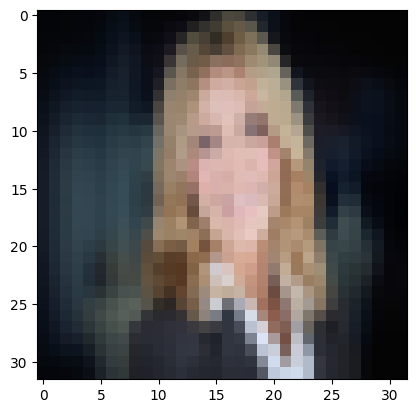

In [113]:
# Checking the Images
def show_example(img, label):
  print('Label: ', dataset.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1, 2, 0))
show_example(*dataset[1010])

In [114]:
# Creating Train and Validation Sets
val_size = 500
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [115]:
# train and validation dataloaders
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [116]:
# Checking the Batch
from torchvision.utils import make_grid
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [117]:
# Creating Functions for our Model
def apply_kernel(image, kernel):
  ri, ci = image.shape # image dimensions
  rk, ck = kernel.shape # kernel dimensions
  ro, co = ri-rk+1, ci-ck+1 # output dimensions
  output = torch.zeros([ro, co])
  for i in range(ro):
    for j in range(co):
      output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
  return output

In [118]:
sample_image = torch.tensor([[3, 3, 2, 1, 0], [0, 0, 1, 3, 1], [3, 1, 2, 2, 3], [2, 0, 0, 2, 2], [2, 0, 0, 0, 1]], dtype=torch.float32)
sample_kernel = torch.tensor([[0, 1, 2], [2, 2, 0], [0, 1, 2]], dtype=torch.float32)
apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [119]:
# Creating the Model
simple_model = nn.Sequential(nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),nn.MaxPool2d(2, 2))

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images) # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss
  def validation_step(self, batch):
    images, labels = batch
    out = self(images) # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    acc = accuracy(out, labels) # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
    epoch, result['train_loss'], result['val_loss'], result['val_acc']))

class class_finder(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
    nn.Flatten(),
    nn.Linear(256*4*4, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10))
  def forward(self, xb):
    return self.network(xb)

In [120]:
model = class_finder()
model

class_finder(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

In [121]:
# GPU Support for Model
def get_default_device():
  #Pick GPU if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
 #Move tensor(s) to chosen device
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
#Wrap a dataloader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
  #Yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)
    def __len__(self):
      #Number of batches
      return len(self.dl)

In [122]:
# Get Device Available
device = get_default_device()

In [123]:
# Convert to train and validation dataloaders
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

class_finder(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

In [124]:
# Creating the Evaluation Function
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [125]:
# Running the Model and Getting Results
model = to_device(class_finder(), device)
evaluate(model, val_dl)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'val_loss': 2.2722463607788086, 'val_acc': 0.6468365788459778}

In [126]:
# set the epochs and learning rate
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [127]:
# store the training in a variable named history
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.9334, val_loss: 0.6610, val_acc: 0.6468
Epoch [1], train_loss: 0.6446, val_loss: 0.6557, val_acc: 0.6468
Epoch [2], train_loss: 0.6407, val_loss: 0.6497, val_acc: 0.6468
Epoch [3], train_loss: 0.6392, val_loss: 0.6362, val_acc: 0.6468
Epoch [4], train_loss: 0.6314, val_loss: 0.6600, val_acc: 0.6468
Epoch [5], train_loss: 0.6282, val_loss: 0.6211, val_acc: 0.6468
Epoch [6], train_loss: 0.6328, val_loss: 0.6762, val_acc: 0.6468
Epoch [7], train_loss: 0.6654, val_loss: 0.6599, val_acc: 0.6468
Epoch [8], train_loss: 0.6395, val_loss: 0.6282, val_acc: 0.6468
Epoch [9], train_loss: 0.6422, val_loss: 0.6302, val_acc: 0.6468


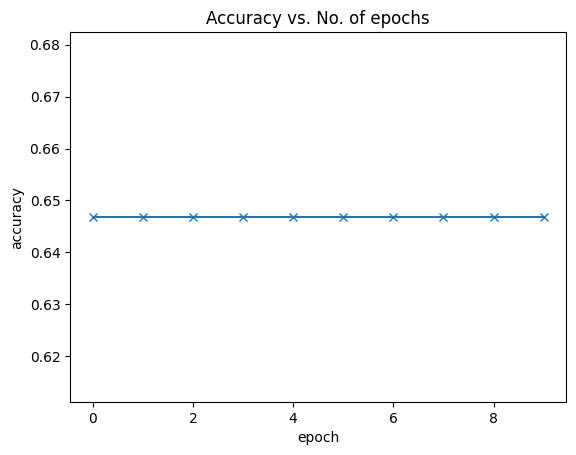

In [135]:
#Plotting our Results
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')
plot_accuracies(history)

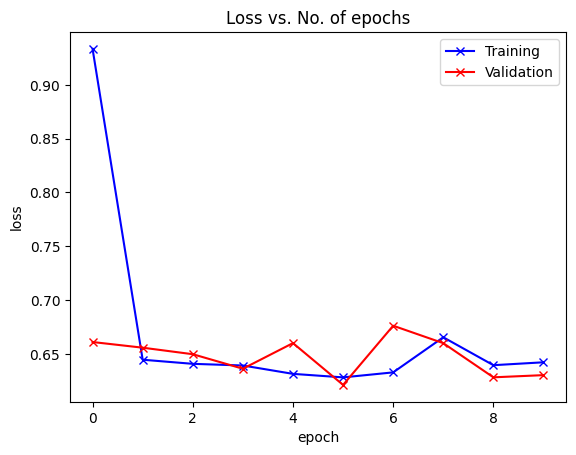

In [129]:
# Plotting Loss
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')
plot_losses(history)

In [130]:
# Checking on the Test Set
t_d = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
test_dataset = ImageFolder(DATA_DIR, transform=t_d)

In [131]:
# predict image function to test on the test set
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds = torch.max(yb, dim=1)
  # Retrieve the class label
  return dataset.classes[preds[0].item()]

Label: women , Predicted: women


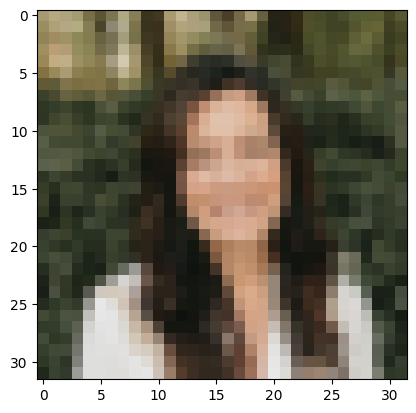

In [132]:
# test on a single image
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [133]:
# test model accuracy on test set
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6097795367240906, 'val_acc': 0.6774088740348816}

In [134]:
# Saving the Model for Future Use
torch.save(model.state_dict(), 'men_women.pth')
model2 = to_device(class_finder(), device)
model2.load_state_dict(torch.load('men_women.pth'))

<All keys matched successfully>